In [212]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
from sklearn.metrics import classification_report,confusion_matrix
import torch.nn.init as init
import os
import torch


In [213]:
device = ''
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device('cpu')
print("Using {}.".format(device))

Using cuda.


In [214]:
# Define radius and center of circle
r = 1
center = (0, 0)

# Define angle range for circle
theta = np.linspace(0, 2*np.pi, 20)

# Generate coordinates for points on circle
x = center[0] + r*np.cos(theta)
y = center[1] + r*np.sin(theta)

# Combine x and y into a single array
data = np.stack((x, y), axis=1)

# Assign alternating labels
labels = np.ones(20)
labels[1::2] = 0
labels=np.asarray([float(i) for i in labels])
print("Data:\n", data)
print("Labels:\n", labels)


Data:
 [[ 1.00000000e+00  0.00000000e+00]
 [ 9.45817242e-01  3.24699469e-01]
 [ 7.89140509e-01  6.14212713e-01]
 [ 5.46948158e-01  8.37166478e-01]
 [ 2.45485487e-01  9.69400266e-01]
 [-8.25793455e-02  9.96584493e-01]
 [-4.01695425e-01  9.15773327e-01]
 [-6.77281572e-01  7.35723911e-01]
 [-8.79473751e-01  4.75947393e-01]
 [-9.86361303e-01  1.64594590e-01]
 [-9.86361303e-01 -1.64594590e-01]
 [-8.79473751e-01 -4.75947393e-01]
 [-6.77281572e-01 -7.35723911e-01]
 [-4.01695425e-01 -9.15773327e-01]
 [-8.25793455e-02 -9.96584493e-01]
 [ 2.45485487e-01 -9.69400266e-01]
 [ 5.46948158e-01 -8.37166478e-01]
 [ 7.89140509e-01 -6.14212713e-01]
 [ 9.45817242e-01 -3.24699469e-01]
 [ 1.00000000e+00 -2.44929360e-16]]
Labels:
 [1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]


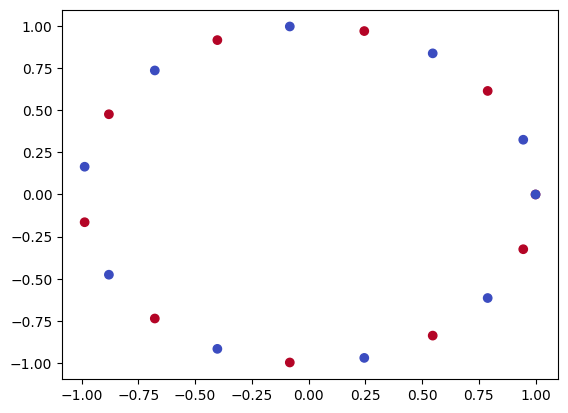

In [215]:

plt.scatter(data[:,0], data[:,1], c=labels, cmap='coolwarm')
plt.show()

In [216]:
class ReconNet(nn.Module):
    def __init__(self):
        super(ReconNet,self).__init__()
        self.layer1 = nn.Linear(2,1000)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(1000,1000)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(1000,1)
        self.sigmoid = nn.Sigmoid()
        self.double()

        init.constant_(self.layer2.bias, 0)
        init.constant_(self.layer3.bias, 0)

        init.normal_(self.layer1.weight, mean=0, std=0.0001)
        init.kaiming_uniform_(self.layer1.weight)
        init.kaiming_uniform_(self.layer2.weight)

    def forward(self,x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        x = self.sigmoid(x)
        return x
      


In [217]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [218]:
dataset = MyDataset(data, labels)
dataloader = DataLoader(dataset, batch_size=20,shuffle=True)

In [219]:
for i in dataloader:
    print(len(i[0]))
#   output=model(i[0])
  # print(output.squeeze(dim=0))
  

20


In [220]:
model=ReconNet().to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
criterion = nn.BCELoss()
 
n_epochs=100000
epochs=tqdm(range(n_epochs))
training_loss_sgd=[]
for epoch in epochs:
  train_loss=[]
  model.train()
  for batch in dataloader:
    optimizer.zero_grad()
    images=batch[0].to(device)
    label=batch[1].to(device)
    output=model(images)
    #print(output.dtype)
    loss=nn.BCELoss()(output.squeeze(),label)
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  loss_now=np.mean(train_loss)
  training_loss_sgd.append(loss_now)
  epochs.set_postfix({'loss':loss_now}) 


100%|██████████| 100000/100000 [08:12<00:00, 203.19it/s, loss=0.0707]


In [221]:
weights_1 = model.layer1.weight.data
weights_2 = model.layer2.weight.data
weights_3 = model.layer3.weight.data
# print(weights_1.shape)
# print(weights_2.shape)
# print(weights_3.shape)

In [222]:
m = 100

In [223]:
x_recons = torch.randn(m, 2,dtype=torch.float64) #creating random x 
lambda_i=torch.rand(m)#creating random lamdas for respective x
optim_x_recons = torch.optim.SGD([x_recons], lr=0.1, momentum=0.9) #making it optimising variable
optim_lambda_i=torch.optim.SGD([lambda_i],lr=0.1,momentum=0.9) #making it optimising variable

In [224]:
x_recons.requires_grad_(True)
lambda_i.requires_grad_(True)
x_recons.dtype

torch.float64

In [225]:
x_recons = x_recons.to(device)
values=model(x_recons)
values = values.to(device)

In [226]:
values=values.reshape(-1)

In [227]:
x_recons #before


tensor([[ 0.4736,  1.0605],
        [-0.2787, -1.3453],
        [ 2.5500, -1.5918],
        [ 0.7076, -1.1484],
        [ 0.0443,  0.6214],
        [-0.4447,  0.4575],
        [-0.1662,  0.4534],
        [ 0.6164, -0.6276],
        [ 0.0730, -1.0349],
        [ 0.9602,  0.8848],
        [-0.3034, -0.7614],
        [ 0.2631, -0.0526],
        [-1.1266, -1.2855],
        [ 1.1229, -0.5498],
        [-0.4495,  0.9492],
        [-1.2748, -0.1467],
        [-0.1627,  0.5744],
        [-0.1753, -0.0960],
        [ 1.4424,  0.2339],
        [ 0.0840,  1.3908],
        [ 0.4083,  0.8790],
        [ 1.5648, -1.0584],
        [-0.1750,  0.4891],
        [-0.0672,  0.0628],
        [-0.1603, -0.1141],
        [-1.9663,  0.5983],
        [-1.4602, -0.9542],
        [ 1.6130,  0.6586],
        [ 1.2073, -1.1344],
        [ 0.4090, -1.1439],
        [-0.2824, -1.1488],
        [-0.4286, -0.0443],
        [-0.3712, -2.1605],
        [-0.1239, -1.7191],
        [-0.3615, -0.6217],
        [ 0.6110,  1

In [228]:
print(lambda_i.shape,y.shape,values.shape)

torch.Size([100]) (20,) torch.Size([100])


In [229]:
lambda_i.dim()

1

In [230]:
y = torch.ones(100)
y[:50] =0

In [231]:
import itertools
def get_kkt_loss(values, lambda_i, y, model):
    lambda_i = lambda_i.squeeze()
    assert values.dim() == 1
    assert lambda_i.dim() == 1
    assert y.dim() == 1
    assert values.shape == lambda_i.shape == y.shape

    output = values * lambda_i * y
    # output = values 
    mult = lambda_i * y
    params = model.parameters()
    grad = torch.autograd.grad(
        outputs=output,
        inputs=model.parameters(),
        grad_outputs=torch.ones_like(mult, requires_grad=False, device=output.device).div(m),
        create_graph=True,
        retain_graph=True,
    )
    kkt_loss = 0
    length = len(list(params))

    # print(length)
    # print(type(list(params)))
    # print(len(grad))
    for i, (p, grad) in enumerate(zip(model.parameters(), grad)):
        assert p.shape == grad.shape
        l = (p.detach().data - grad).pow(2).sum()
        kkt_loss += l
    return kkt_loss

In [232]:
lambda_i = lambda_i.to(device)
y = y.to(device)
kkt_loss=get_kkt_loss(values,lambda_i,y,model)
print(type(lambda_i))
# print(kkt_loss)
# print(values.dim())
# print(lambda_i[0].shape)
# print(y.dim())
# print(values)

<class 'torch.Tensor'>


In [233]:
kkt_loss = get_kkt_loss(values,lambda_i,y,model)
print(kkt_loss)

tensor(4325.0681, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


In [234]:
def get_verify_loss(x, l):
    loss_verify = 0
    loss_verify += 1 * (x - 1).relu().pow(2).sum()
    loss_verify += 1 * (-1 - x).relu().pow(2).sum()
    loss_verify += 5 * (-l + 0.4983026413803425).relu().pow(2).sum()
    return loss_verify

In [235]:
def getLambdaLoss(lambda_i):
    temp = list(lambda_i)
    loss_lambda = 0
    for l in lambda_i:
        loss_lambda += max(-1 * l,0)
    return loss_lambda

In [236]:
loss_verify=get_verify_loss(x_recons,lambda_i)
loss_lambda = getLambdaLoss(lambda_i)
print(loss_lambda)

0


In [ ]:
for epoch in range(100000):
        values = model(x_recons).squeeze()
        kkt_loss, loss_verify =get_kkt_loss(values,lambda_i,y,model),get_verify_loss(x_recons,lambda_i)
        # loss=kkt_loss+loss_verify
        lambda_loss = getLambdaLoss(lambda_i)
        loss=kkt_loss + lambda_loss
        if np.isnan(kkt_loss.item()):
            raise ValueError('Optimizer diverged during extraction')
        optim_x_recons.zero_grad()
        optim_lambda_i.zero_grad()
        loss.backward()
        optim_x_recons.step()
        optim_lambda_i.step()
        if(epoch%1000==0):
            print(epoch," ",kkt_loss," ",loss)
        

0   tensor(4325.0681, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)   tensor(4325.0681, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
1000   tensor(4325.0681, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)   tensor(4325.0681, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
2000   tensor(4325.0681, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)   tensor(4325.0681, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
3000   tensor(4325.0681, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)   tensor(4325.0681, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
4000   tensor(4325.0681, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)   tensor(4325.0681, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
5000   tensor(4325.0681, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)   tensor(4325.0681, device='cuda:0', dtype=torch.float64, grad_fn=<AddB

In [ ]:
kkt_loss

In [ ]:
x_recons = x_recons.cpu()
y = y.cpu()
plt.scatter(x_recons[:,0].detach().numpy(), x_recons[:,1].detach().numpy(), c=y, cmap='coolwarm')
plt.show()

In [ ]:
model.parameters

<bound method Module.parameters of SimpleMLP(
  (mlp1): Linear(in_features=2, out_features=1000, bias=True)
  (mlp2): Linear(in_features=1000, out_features=1000, bias=True)
  (mlp3): Linear(in_features=1000, out_features=1, bias=True)
  (l4): Sigmoid()
)>

In [ ]:
y

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
l_updated=[]
for i in range(len(l)):
  if(l[i]<5):
    l_updated.append(i)

In [ ]:
x_after_removing_lambda=[x_recons[i] for i in l_updated]

In [ ]:
y_updated=[y[i] for i in l_updated]

In [ ]:
for i in x_after_removing_lambda:
  i=torch.tensor(i)

In [ ]:
for i in x_after_removing_lambda:
  i=i.tolist()

In [ ]:
x_after_removing_lambda

[tensor([0.6181, 0.5252], dtype=torch.float64, grad_fn=<SelectBackward0>),
 tensor([-0.7065,  0.8584], dtype=torch.float64, grad_fn=<SelectBackward0>),
 tensor([0.6531, 0.3014], dtype=torch.float64, grad_fn=<SelectBackward0>),
 tensor([-0.1120,  0.0383], dtype=torch.float64, grad_fn=<SelectBackward0>),
 tensor([0.5559, 0.6274], dtype=torch.float64, grad_fn=<SelectBackward0>),
 tensor([0.7814, 0.7718], dtype=torch.float64, grad_fn=<SelectBackward0>),
 tensor([0.1096, 0.5670], dtype=torch.float64, grad_fn=<SelectBackward0>),
 tensor([0.1627, 0.2822], dtype=torch.float64, grad_fn=<SelectBackward0>),
 tensor([-0.5800,  0.1526], dtype=torch.float64, grad_fn=<SelectBackward0>),
 tensor([ 0.7463, -0.0726], dtype=torch.float64, grad_fn=<SelectBackward0>),
 tensor([-0.5913, -0.1039], dtype=torch.float64, grad_fn=<SelectBackward0>),
 tensor([-0.0963, -0.6246], dtype=torch.float64, grad_fn=<SelectBackward0>),
 tensor([ 0.8689, -0.6275], dtype=torch.float64, grad_fn=<SelectBackward0>),
 tensor([-0

In [ ]:
x_recons_list=x_recons.tolist()

In [ ]:
x_recons_list=[x_recons_list[i] for i in l_updated]

In [ ]:
x_recons_list

[[0.6181474467960141, 0.5251645127321973],
 [-0.706477931292861, 0.8584289464878847],
 [0.6530623090735923, 0.30140598661403883],
 [-0.11196191244728841, 0.03829231132385157],
 [0.5558789214283211, 0.627430306532399],
 [0.7814269653519305, 0.7718471685609745],
 [0.10962087792618812, 0.5670485736015184],
 [0.16271585346793266, 0.282165273731458],
 [-0.579966107751664, 0.152590340940237],
 [0.7462525614205648, -0.07264541163739435],
 [-0.5912614689672671, -0.10389781516098857],
 [-0.09634714889306593, -0.6245780292582993],
 [0.8688783348977086, -0.6275323313601769],
 [-0.4183153758516972, 0.38950951629513547],
 [-0.8413319003002175, 0.37111790252705856],
 [-0.3852682064824513, 0.8333454519063085],
 [-0.6940413299756708, -0.19997020796917048],
 [0.5289090241261352, -0.8680496371004321],
 [0.3150547703615553, 0.655025618742167],
 [-0.7852195719429897, 0.49791996539953287],
 [-0.5597919256074679, -0.03262313687626811],
 [0.11341970942932339, 0.5333223480762428],
 [0.736506762474211, -0.9715

In [ ]:
y

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
l_updated #contains indices of l with l<5

[1,
 3,
 4,
 5,
 6,
 7,
 8,
 10,
 13,
 14,
 15,
 16,
 17,
 19,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 31,
 33,
 35,
 36,
 37,
 38,
 39,
 40,
 42,
 44,
 45,
 46,
 48,
 50,
 51,
 53,
 54,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 66,
 68,
 69,
 70,
 71,
 72,
 74,
 75,
 76,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]